The dataset is structured into two folders: `fresh` and `stale`. For ease of use, declare paths for each.

In [1]:
import os

dataset_dir = './data'
fresh_path = os.path.join(dataset_dir, 'fresh')
stale_path = os.path.join(dataset_dir, 'stale')

Sample an image from the dataset.

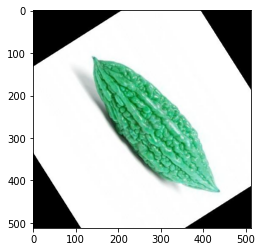

In [2]:
import cv2
import matplotlib.pyplot as plt

plt.imshow(cv2.imread(os.path.join(fresh_path, os.listdir(fresh_path)[0])))

For preprocessong, ensure that all of the images are of the same size, which would be `128x128`.

In [3]:
import tensorflow as tf

def preproc(img):
    img = img/255.0
    with tf.device('/cpu:0'):
        img = tf.image.resize(img, [128, 128])
    return img

Collect the data and label each of them. For this model, fresh fruits are labeled with `0` while stale fruits are labeled with `1`.

In [4]:
def get_data(dir_path, label):
    X = []
    y = []
    
    for filename in os.listdir(dir_path):
        img = cv2.imread(os.path.join(dir_path, filename))
        img = preproc(img)
        X.append(img)
        y.append(label)
    
    return X, y

def get_data_with_labels():
    X_0, y_0 = get_data(dir_path=fresh_path, label=0)
    X_1, y_1 = get_data(dir_path=stale_path, label=1)
    
    X = X_0+X_1
    y = y_0+y_1
    
    return X, y

In [5]:
X, y = get_data_with_labels()

Split the data into three categories: `train`, `test`, and `validate`.

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_t, y_train, y_t = train_test_split(np.array(X), np.array(y), test_size=0.1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=0.5, stratify=y_t)

Training 8gb worth of data takes time. To make training faster, both CPU and GPU will be used, if possible. However, 8gb is still a lot so it cannot fit into most GPU's memory. To address this problem, create a `DataGenerator` class that only places data into the GPU's memory whenever necessary by using smaller batches.

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size):
        self.x, self.y = x, y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = tf.convert_to_tensor(self.x[idx * self.batch_size:(idx + 1) * self.batch_size])
        batch_y = tf.convert_to_tensor(self.y[idx * self.batch_size:(idx + 1) * self.batch_size])
        return batch_x, batch_y

In [8]:
BATCH_SIZE = 16

train_gen = DataGenerator(X_train, y_train, BATCH_SIZE)
test_gen = DataGenerator(X_test, y_test, BATCH_SIZE)
val_gen = DataGenerator(X_val, y_val, BATCH_SIZE)

Define the model. For this project, it will be a CNN with 4 pairs of convolution-pooling layers of increasing filter sizes, followed by a flattening layer, then three dense layers.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU

In [33]:
model = tf.keras.Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation=LeakyReLU(alpha=0.02), input_shape=(128, 128, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation=LeakyReLU(alpha=0.01), padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Flatten())

model.add(Dense(units=32, activation=LeakyReLU(alpha=0.05)))
model.add(Dense(units=32, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 32)      

Compile the model. For optimizer, use `Adam`. For the loss and metrics, since an image can either only be fresh or stale, use `binary`.

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)

Train the model.

In [35]:
EPOCHS = 30

history = model.fit(train_gen, verbose=1, validation_data=val_gen, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.4670 - binary_accuracy: 0.7613 - val_loss: 0.3077 - val_binary_accuracy: 0.8600
Epoch 2/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.2798 - binary_accuracy: 0.8814 - val_loss: 0.2516 - val_binary_accuracy: 0.8905
Epoch 3/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.2058 - binary_accuracy: 0.9158 - val_loss: 0.1950 - val_binary_accuracy: 0.9184
Epoch 4/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.1641 - binary_accuracy: 0.9344 - val_loss: 0.1555 - val_binary_accuracy: 0.9416
Epoch 5/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.1301 - binary_accuracy: 0.9497 - val_loss: 0.1425 - val_binary_accuracy: 0.9356
Epoch 6/30
1696/1696 [==============================] - 19s 11ms/step - loss: 0.1056 - binary_accuracy: 0.9600 - val_loss: 0.1113 - val_binary_accuracy: 0.9575
Epoch 7/30
1696/1696 [==================

Save the model for future use.

In [41]:
model.save('mymodelv1.3.h5')

Do multiple tests to evaulate the model.

In [36]:
test_img = cv2.imread('rot.jpg')
test_img = preproc(test_img)
test_img = tf.expand_dims(test_img, axis=0)
model.predict(test_img)

1/1 [==============================] - 0s 188ms/step


array([[0.9999988]], dtype=float32)

In [37]:
test_img = cv2.imread('fresh.jpg')
test_img = preproc(test_img)
test_img = tf.expand_dims(test_img, axis=0)
model(test_img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00467968]], dtype=float32)>

In [38]:
model.evaluate(X_test, y_test)

48/48 [==============================] - 0s 7ms/step - loss: 0.1186 - binary_accuracy: 0.9728


[0.11860281229019165, 0.9727936387062073]

Use Classification Report and Confusion Matrix to analyze the accuracy of the model.

In [39]:
y_pred = model.predict(X_test)
y_pred = (y_pred.reshape(1,-1)[0] > 0.4).astype(int)

48/48 [==============================] - 0s 6ms/step


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       716
           1       0.97      0.97      0.97       791

    accuracy                           0.97      1507
   macro avg       0.97      0.97      0.97      1507
weighted avg       0.97      0.97      0.97      1507



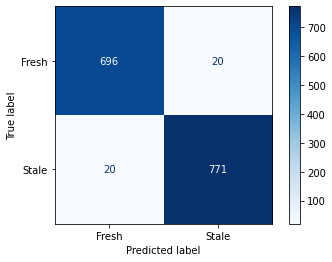

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["Fresh", "Stale"]

print(classification_report(y_pred, y_test))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()